# Treinamento de Rede Neural com Tensorflow para análise do sinal

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from libs.commpy_mod import SISOFlatChannel

from files_01_detection.const_mod import generate_symbols, Model
from files_01_detection.const_analyzer import plot_decision_boundary, theoretical_ser, ser, plot_confusion_matrix, plot_symbols
 
%matplotlib inline

2022-12-04 17:18:27.326977: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-04 17:18:28.234227: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-04 17:18:28.234249: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-04 17:18:28.353898: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-04 17:18:30.685451: W tensorflow/stream_executor/platform/de

## Definição e transmissão do sinal pelo canal

In [2]:
Mod = 'PSK'
channel_type = 'rayleigh' # 'awgn' or 'crazy'
M            = 8      # PSK modulation
total_num_symbols  = 1000000    # Number of transmitted symbols to be used for training and test
train_fraction = 0.5 # Fraction of whole data to be used for training (the remaining is for testing)
SNR_dB       = 15      # Signal to noise ratio in dB     
code_rate    = 1       # Rate of the used code
Es           = 1       # Average symbol energy

In [3]:
#plot theoretical symbol error probability (SER) for this SNR
Pe = theoretical_ser(Mod, M, SNR_dB, channel_type, Es)
print("Theoretical symbol error probability (SER) =", 100.0*Pe, "% for SNR =", SNR_dB,"dB")

Theoretical symbol error probability (SER) = 44.75173852031923 % for SNR = 15 dB


In [4]:
symbs, indices, channel_output = Model(Mod, total_num_symbols, M, channel_type, Es, code_rate, SNR_dB)

In [5]:
# Generate dataset
# Train
train_size = int(train_fraction*total_num_symbols) #data used for training
y_train = np.append(np.array([[]]), indices[:train_size])
X_train = np.stack([np.real(channel_output[:train_size]),
                    np.imag(channel_output[:train_size])], axis=1)

# Test
y_test = np.append(np.array([[]]), indices[train_size:])
X_test = np.stack([np.real(channel_output[train_size:]),
                   np.imag(channel_output[train_size:])], axis=1)

scaler = StandardScaler()
scaler.fit(X_train)  # Don't cheat - fit only on training data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

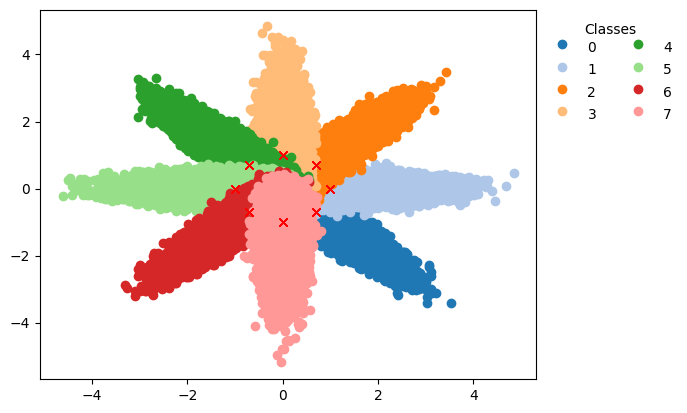

In [6]:
plot_symbols(X_train, y_train, M, symbs)

## Criação e treinamento da Rede Neural

In [63]:
n_inputs = np.shape(X_train)[1]
n_hidden1 = 50
n_hidden2 = 30
n_outputs = M
learning_rate = 0.001
n_epochs = 100
batch_size = 5000

y_train = tf.reshape(tf.convert_to_tensor(y_train), [-1, 1])
y_test = tf.reshape(tf.convert_to_tensor(y_test), [-1, 1])
X_test = tf.convert_to_tensor(X_test)
X_train = tf.convert_to_tensor(X_train)

### Usando API Keras

In [64]:
inputs = tf.keras.Input(shape=(2,))

x = tf.keras.layers.Dense(n_hidden1, activation="relu", kernel_initializer="glorot_normal")(inputs)
x = tf.keras.layers.Dense(n_hidden2, activation="relu", kernel_initializer="glorot_normal")(x)
output = tf.keras.layers.Dense(n_outputs, kernel_initializer="glorot_normal")(x)

modelK = tf.keras.Model(inputs=inputs, outputs=output)

modelK.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_12 (Dense)            (None, 50)                150       
                                                                 
 dense_13 (Dense)            (None, 30)                1530      
                                                                 
 dense_14 (Dense)            (None, 8)                 248       
                                                                 
Total params: 1,928
Trainable params: 1,928
Non-trainable params: 0
_________________________________________________________________


In [65]:
modelK.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
             metrics=["accuracy"])

history = modelK.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, shuffle=True)

tests_score = modelK.evaluate(X_test, y_test)
print("Test loss:", tests_score[0])
print("Test accuracy:", tests_score[1])
print(f"Taxa de erro simbólica de {(1 - tests_score[1]):.2%}")

Epoch 1/100
100/100 [==============================] - 1s 6ms/step - loss: 2.1200 - accuracy: 0.0397
Epoch 2/100
100/100 [==============================] - 1s 6ms/step - loss: 2.0991 - accuracy: 0.0869
Epoch 3/100
100/100 [==============================] - 1s 6ms/step - loss: 2.0794 - accuracy: 0.1717
Epoch 4/100
100/100 [==============================] - 1s 6ms/step - loss: 2.0608 - accuracy: 0.1849
Epoch 5/100
100/100 [==============================] - 1s 6ms/step - loss: 2.0430 - accuracy: 0.2082
Epoch 6/100
100/100 [==============================] - 1s 6ms/step - loss: 2.0256 - accuracy: 0.2817
Epoch 7/100
100/100 [==============================] - 1s 6ms/step - loss: 2.0079 - accuracy: 0.3444
Epoch 8/100
100/100 [==============================] - 1s 6ms/step - loss: 1.9899 - accuracy: 0.4022
Epoch 9/100
100/100 [==============================] - 1s 6ms/step - loss: 1.9721 - accuracy: 0.4488
Epoch 10/100
100/100 [==============================] - 1s 6ms/step - loss: 1.9546 - accura

### Modelo de Rede Neural Criado

In [48]:
y_test = tf.cast(tf.reshape(y_test, -1),tf.int32)
y_train = tf.cast(tf.reshape(y_train, -1),tf.int32)

In [49]:
class DenseLayer(tf.Module):
    def __init__(self, n_neurons, name=None):
        super().__init__(name=name)
        self.n_neurons = n_neurons
        self.is_built = False
        
    def __call__(self, X, activation=None, name=None):
        if not self.is_built:
            self.w = tf.Variable(tf.random.truncated_normal((X.shape[-1], self.n_neurons), stddev=(2 / tf.sqrt(tf.cast(self.n_neurons + X.shape[-1], tf.float32)))), name=str(name)+"W")
            self.b = tf.Variable(tf.zeros([self.n_neurons]), dtype=tf.float32, name=str(name)+"b")
            self.is_built = True
            
        Z = tf.matmul(X, self.w) + self.b
        if activation is None:
            return Z
        else:
            return activation(Z)

In [50]:
class SequencialModel(tf.Module):
    def __init__(self, n_hidden=None, name=None):
        super().__init__(name=name)
        
        self.hidden1 = DenseLayer(n_hidden1)
        self.hidden2 = DenseLayer(n_hidden2)
        self.output = DenseLayer(n_outputs)
    
    def __call__(self, X):
        x = self.hidden1(tf.cast(X, tf.float32), activation=tf.nn.relu, name="hidden1-")
        x = self.hidden2(x, activation=tf.nn.relu, name="hidden2-")
        
        return self.output(x, name="output-")

In [51]:
model = SequencialModel()

In [52]:
def loss(y, logits):
    return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits))

In [53]:
def train(model, x, y, learning_rate):
    with tf.GradientTape() as g:
        current_loss = loss(y, tf.cast(model(x), tf.float32))
        
    dp = g.gradient(current_loss, model.trainable_variables)
    
    for i in range(len(model.trainable_variables)):
        model.trainable_variables[i].assign_sub(learning_rate * dp[i])

In [54]:
def minilote(model, x, y):
    for _ in range(n_epochs):
        for interation in range(x.shape[0] // batch_size):
            X_batch, y_batch = x[interation*batch_size:(interation+1)*batch_size], y[interation*batch_size:(interation+1)*batch_size]
            train(model, X_batch, y_batch, learning_rate)
        print(f"Época número {_}, precisão de {accuracy(model, x, y):.2%}")

In [55]:
def accuracy(model, x, y):
    correct = tf.nn.in_top_k(y, model(x), 1)
    return tf.reduce_mean(tf.cast(correct, tf.float32))

In [56]:
minilote(model, X_train, y_train)

Época número 0, precisão de 93.53%
Época número 1, precisão de 90.92%
Época número 2, precisão de 85.70%
Época número 3, precisão de 83.59%
Época número 4, precisão de 82.17%
Época número 5, precisão de 79.45%
Época número 6, precisão de 77.38%
Época número 7, precisão de 76.12%
Época número 8, precisão de 74.75%
Época número 9, precisão de 73.41%
Época número 10, precisão de 72.86%
Época número 11, precisão de 72.25%
Época número 12, precisão de 71.56%
Época número 13, precisão de 71.21%
Época número 14, precisão de 71.04%
Época número 15, precisão de 70.91%
Época número 16, precisão de 70.82%
Época número 17, precisão de 70.68%
Época número 18, precisão de 70.47%
Época número 19, precisão de 70.23%
Época número 20, precisão de 69.91%
Época número 21, precisão de 69.53%
Época número 22, precisão de 69.11%
Época número 23, precisão de 68.67%
Época número 24, precisão de 68.18%
Época número 25, precisão de 67.71%
Época número 26, precisão de 67.21%
Época número 27, precisão de 66.68%
Ép

In [57]:
print(f"Taxa de erro simbólica de {(1 - accuracy(model, x, y)):.2%}")

<tf.Tensor: shape=(), dtype=float32, numpy=0.585264>